In [1]:
#Packages for data loading, data analysis, and data preparation
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE

#Packages for model evaluation and classification models
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from pickle import dump
from pickle import load

import tensorflow as tf
import keras
import keras_tuner
from keras import layers

#correct the code for one format
import matplotlib.pyplot as plt

#pd.set_option('display.max_columns', None)

In [2]:
keras.utils.set_random_seed(1000)

In [3]:
df = pd.read_csv('onehot.csv')

In [4]:
flag = pd.read_csv('flag.csv')
flag.rename(columns={"Rndrng_NPI": "NPI"}, inplace = True)

C:\Users\ronal\AppData\Local\Temp\ipykernel_15400\1965021019.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  flag = pd.read_csv('flag.csv')


In [5]:
merged_df = df.merge(flag[['NPI','flag', 'hcpcs_flag']], on='NPI', how='left')

In [6]:
merged_df['target'] = np.where((merged_df.eligibility == 1) | (merged_df.flag != 0) | (merged_df.hcpcs_flag != 0), 1, 0)


In [7]:
df = merged_df.drop(columns = ['NPI', 'eligibility', 'flag', 'hcpcs_flag'], axis = 1)

In [8]:
df.head()

,Gndr_F,Gndr_M,Gndr_O,State_Abrvtn_AA,State_Abrvtn_AE,State_Abrvtn_AK,State_Abrvtn_AL,State_Abrvtn_AP,State_Abrvtn_AR,State_Abrvtn_AS,...,Type_Vascular Surgery,Place_Of_Srvc_F,"Place_Of_Srvc_F, O",Place_Of_Srvc_O,"Place_Of_Srvc_O, F",Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Stdzd_Amt,target
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.038814,0.086846,-0.270365,-0.180985,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.135430,0.138674,-0.241973,-0.414999,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.031064,-0.013540,-0.223454,0.001080,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.057107,-0.039419,-0.377797,-0.360670,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.057134,-0.039454,-0.151161,-0.226828,0


# 20% Train and Test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['target'], axis = 1), df.target, test_size=0.3, stratify = df.target, random_state=42)

In [10]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)

In [11]:
%%time
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Wall time: 10min 22s


# Model 

In [21]:
%%time
model = keras.Sequential()
model.add(layers.Dense(198))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Recall()],
)

history = model.fit(X_train_smote, y_train_smote, epochs=1, validation_data=(X_val, y_val))
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")

5267/5267 [==============================] - 6s 1ms/step - loss: 0.6729 - accuracy: 0.6374 - recall_2: 0.7016
Test Accuracy: 0.6374
Test Recall: 0.7016
Wall time: 1min 19s


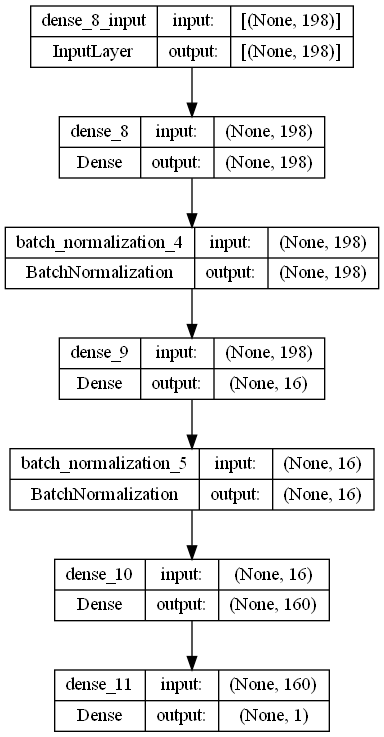

In [23]:
keras.utils.plot_model(model, to_file='my_model.png', show_shapes=True)

# Model with old target

In [14]:
df2 = pd.read_csv('onehot.csv')
df2 = df2.drop(columns = ['NPI'], axis = 1)

In [15]:
df2.head()

,Gndr_F,Gndr_M,Gndr_O,State_Abrvtn_AA,State_Abrvtn_AE,State_Abrvtn_AK,State_Abrvtn_AL,State_Abrvtn_AP,State_Abrvtn_AR,State_Abrvtn_AS,...,Type_Vascular Surgery,Place_Of_Srvc_F,"Place_Of_Srvc_F, O",Place_Of_Srvc_O,"Place_Of_Srvc_O, F",Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Stdzd_Amt,eligibility
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.038814,0.086846,-0.270365,-0.180985,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.135430,0.138674,-0.241973,-0.414999,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.031064,-0.013540,-0.223454,0.001080,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.057107,-0.039419,-0.377797,-0.360670,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.057134,-0.039454,-0.151161,-0.226828,0


In [16]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df2.drop(columns = ['eligibility'], axis = 1), df2.eligibility, test_size=0.3, stratify = df2.eligibility, random_state=42)

In [17]:
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_test1, y_test1, test_size=0.5, stratify = y_test1, random_state=42)

In [18]:
%%time
smote = SMOTE(random_state=42)
X_train_smote1, y_train_smote1 = smote.fit_resample(X_train1, y_train1)

Wall time: 10.9 s


In [22]:
%%time
model1 = keras.Sequential()
model1.add(layers.Dense(198))
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(160, activation='relu'))
model1.add(layers.Dense(1, activation="sigmoid"))
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Recall()],
)

history1 = model1.fit(X_train_smote1, y_train_smote1, epochs=1, validation_data=(X_val1, y_val1))
test_loss1, test_accuracy1, test_recall1 = model.evaluate(X_test1, y_test1)

print(f"Test Accuracy: {test_accuracy1:.4f}")
print(f"Test Recall: {test_recall1:.4f}")

5267/5267 [==============================] - 6s 1ms/step - loss: 0.8324 - accuracy: 0.5412 - recall_2: 0.3750
Test Accuracy: 0.5412
Test Recall: 0.3750
Wall time: 1min 39s


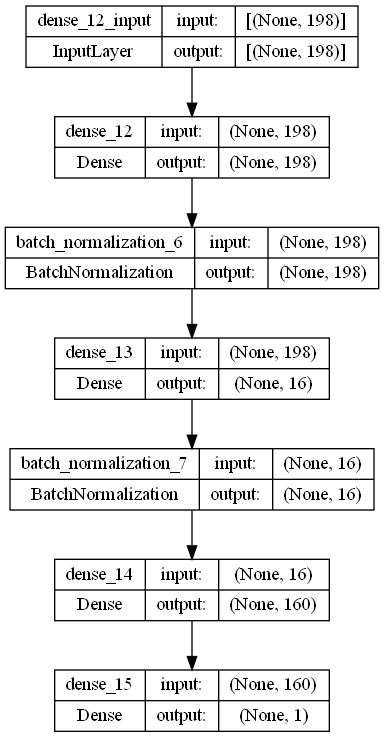

In [24]:
keras.utils.plot_model(model1, to_file='my_model.png', show_shapes=True)